In [4]:
import numpy as np

import lunar_lander
from turbo_test import demo_heuristic_lander
import tensorflow as tf
import trieste

In [5]:
# this space is created by doing +-0.1 around parameter values
# set in https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py
# search_space = trieste.space.Box(
#     [0.4, 0.9, 0.3, 0.5, 0.4, 0.9, 0.4, 0.4, 0.0, 0.5, 0.0, 0.0],
#     [0.6, 1.1, 0.5, 0.6, 0.6, 1.1, 0.6, 0.6, 0.1, 0.6, 0.1, 0.1]
# )

search_space = trieste.space.Box([0.0], [1.5]) ** 12

In [6]:
OBJECTIVE = "OBJECTIVE"
# lander crashed
CRASH = "CRASH"
# didn't finish in predefined number of steps
TIMEOUT = "TIMEOUT"
# lander landed fine, but outside the helipad
OUTSIDE = "OUTSIDE"

create_empty_dataset = lambda : trieste.data.Dataset(tf.zeros((0, search_space.dimension), tf.float64), tf.zeros((0, 1), tf.float64))

def lander_observer(x):
    all_datasets = {
        OBJECTIVE: create_empty_dataset(),
        CRASH: create_empty_dataset(),
        TIMEOUT: create_empty_dataset(),
        OUTSIDE: create_empty_dataset()
    }

    def add_data(dataset_tag, x, y):
        new_dataset = trieste.data.Dataset(np.atleast_2d(x), np.atleast_2d(y))
        all_datasets[dataset_tag] += new_dataset

    for w in x.numpy():
        result = demo_heuristic_lander(lunar_lander.LunarLander(), w)
        if result.timeout:
            add_data(TIMEOUT, w, 0.0)
            continue
        else:
            add_data(TIMEOUT, w, 1.0)

        if result.has_crashed:
            add_data(CRASH, w, 0.0)
            continue
        else:
            add_data(CRASH, w, 1.0)

        if not result.is_in_helipad:
            add_data(OUTSIDE, w, 0.0)
            continue
        else:
            add_data(OUTSIDE, w, 1.0)

        # all failure modes are done, means we landed successfully
        normalized_fuel = np.float64(result.total_fuel / 100.0)
        add_data(OBJECTIVE, w, normalized_fuel)
    
    return all_datasets

In [7]:
num_initial_points = 1
initial_query_points = search_space.sample(1)
initial_data = lander_observer(initial_query_points)

# collect points until we have at least one in each dataset
while any(len(initial_data[tag]) == 0 for tag in initial_data):
    initial_query_points = search_space.sample(1)
    new_initial_data = lander_observer(initial_query_points)
    for tag in initial_data:
        initial_data[tag] = initial_data[tag] + new_initial_data[tag]
    num_initial_points += 1

DemoHeuristicResult: reward: -58.54, fuel: 2.73, steps: 60.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -271.86, fuel: 11.40, steps: 99.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -105.10, fuel: 0.60, steps: 55.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -320.88, fuel: 17.40, steps: 84.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -34.64, fuel: 5.16, steps: 58.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -55.69, fuel: 4.80, steps: 65.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -286.76, fuel: 30.60, steps: 136.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -107.75, fuel: 0.39, steps: 58.0, crashed: True, timeout:

In [8]:
num_initial_points

31

In [20]:
import gpflow
from trieste.models.gpflow.models import GaussianProcessRegression, VariationalGaussianProcess
from trieste.models.optimizer import BatchOptimizer

def create_regression_model(data):
    kernel = gpflow.kernels.Matern52(lengthscales=[0.2]*int(search_space.dimension))
    gpr = gpflow.models.GPR(data.astuple(), kernel)
    gpr.likelihood.variance = np.float64(0.1)
    # gpflow.set_trainable(gpr.likelihood, False)
    return gpr


def create_classification_model(data):
    kernel = gpflow.kernels.SquaredExponential(
        lengthscales=[0.2]*int(search_space.dimension)
    )
    likelihood = gpflow.likelihoods.Bernoulli()
    vgp = gpflow.models.VGP(data.astuple(), kernel, likelihood)
    # gpflow.set_trainable(vgp.kernel.variance, False)
    return vgp


models = {
    OBJECTIVE: GaussianProcessRegression(create_regression_model(initial_data[OBJECTIVE])),
    CRASH: VariationalGaussianProcess(
        create_classification_model(initial_data[CRASH]), BatchOptimizer(tf.optimizers.Adam(1e-3)), use_natgrads=True
    ),
    TIMEOUT: VariationalGaussianProcess(
        create_classification_model(initial_data[TIMEOUT]), BatchOptimizer(tf.optimizers.Adam(1e-3)), use_natgrads=True
    ),
    OUTSIDE: VariationalGaussianProcess(
        create_classification_model(initial_data[OUTSIDE]), BatchOptimizer(tf.optimizers.Adam(1e-3)), use_natgrads=True
    ),
}

In [21]:
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.acquisition import (
    SingleModelAcquisitionBuilder, Product
)

from hacks import HackedExpectedImprovement

class ProbabilityOfValidity(SingleModelAcquisitionBuilder):
    def prepare_acquisition_function(self, model, dataset=None):
        def acquisition(at):
            mean, _ = model.predict_y(tf.squeeze(at, -2))
            return mean
        return acquisition

acq_fn = Product(
    HackedExpectedImprovement().using(OBJECTIVE),
    ProbabilityOfValidity().using(CRASH),
    ProbabilityOfValidity().using(TIMEOUT),
    ProbabilityOfValidity().using(OUTSIDE),
)
rule = EfficientGlobalOptimization(acq_fn)

In [22]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(lander_observer, search_space)
result = bo.optimize(30, initial_data, models, rule).final_result.unwrap()

2021-12-03 16:11:14.581253: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-12-03 16:11:15.583410: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-03 16:11:15.603323: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz


DemoHeuristicResult: reward: -18.02, fuel: 18.09, steps: 114.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -10.20, fuel: 9.99, steps: 94.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -67.59, fuel: 6.90, steps: 68.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -24.67, fuel: 17.55, steps: 117.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -48.99, fuel: 28.32, steps: 182.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -7.01, fuel: 39.96, steps: 256.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -48.09, fuel: 16.14, steps: 118.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -93.68, fuel: 7.05, steps: 64.0, crashed: True, timeout

In [23]:
data = result.datasets

In [24]:
for tag in [OBJECTIVE, CRASH, TIMEOUT, OUTSIDE]:
    print(f"{tag}: {len(data[tag])}")

OBJECTIVE: 1
CRASH: 59
TIMEOUT: 61
OUTSIDE: 2


In [25]:
import importlib.util
spec = importlib.util.spec_from_file_location("plotting", "../docs/notebooks/util/plotting.py")
plotting = importlib.util.module_from_spec(spec)
spec.loader.exec_module(plotting)

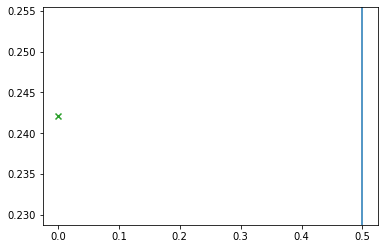

In [26]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from trieste.acquisition import AcquisitionFunction
from trieste.types import TensorType
from trieste.utils import to_numpy
from trieste.acquisition.multi_objective.dominance import non_dominated



fig, ax = plt.subplots(1, 1)
plotting.plot_regret(
    data[OBJECTIVE].observations.numpy(),
    ax,
    num_init=len(initial_data[OBJECTIVE])
)

